# Building a Personalized Post and Subreddit Recommendation System

## DCIT316: Computational Models for Social Media Mining

## Project Description

Reddit, a social media platform with over 1.660 billion monthly active users and more than 130,000 subreddits, serves as a massive repository of user-generated content. While this large number of data offers a rich variety of topics, it also poses a challenge for users trying to find content that aligns with their interests. This project aims to address this issue by developing a personalized post and subreddit recommendation system. Leveraging the Reddit Self-Post Classification Task (RSPCT) dataset, which comprises 1.013 million self-posts across 1013 subreddits. The study involved several key steps, starting with data acquisition and environment preparation on the Kaggle platform. Data preprocessing was performed using Pandas and scikit-learn libraries. The Data preprocessing stage was focused on handling missing values, feature engineering, and normalization. Natural Language Processing (NLP) techniques were applied for text analysis, and data visualization was conducted using Seaborn and Matplotlib. The text data was vectorized using Term Frequency-Inverse Document Frequency (TF-IDF) for machine learning modeling and evaluation. Two algorithms were evaluated for the recommendation system: Naïve Bayes and Single Value Decomposition (SVD) for collaborative filtering. Both models were assessed based on precisionat-k metrics. The study also included an exploratory data analysis to understand user behavior and subreddit themes better.

From a business perspective, the recommendation system aims to increase user engagement, thereby creating more opportunities for advertising and monetization. Overall, this study presents a comprehensive approach to understanding user behavior on Reddit and offers a scalable solution for personalized content recommendation.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/reddit-selfposts/rspct.tsv
/kaggle/input/reddit-selfposts/subreddit_info.csv


Link to dataset on kaggle: https://www.kaggle.com/datasets/mswarbrickjones/reddit-selfposts

# 1. Import Modules

In [ ]:
# regular expressions
import re

# data visualization and manipulation
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# nlp
import nltk
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error

# Package Installation

In [ ]:
#install implicit library
!pip install implicit

In [ ]:
# install textblob package
!python -m pip install textblob

## 1. Data Preprocessing

In [ ]:
# Load the rspct.tsv file
rspct_data = pd.read_csv('/kaggle/input/reddit-selfposts/rspct.tsv', sep='\t')

# Load the subreddit_info.csv file
subreddit_info = pd.read_csv('/kaggle/input/reddit-selfposts/subreddit_info.csv')

In [ ]:
subreddit_info.shape

(3394, 6)

Challenge: The dataset is too large and exhaust the free subscription of Google Colab so we randomly reshuffle it and split it into five.

In [ ]:
# Shuffle the dataset
shuffled_data = rspct_data.sample(frac=1, random_state=42)

# Split the dataset into two halves
split_point = len(shuffled_data) // 2
half_data_1 = shuffled_data[:split_point]
half_data_2 = shuffled_data[split_point:]

In [ ]:
half_data_1.to_csv('half_data_1', index=False)

In [ ]:
working_data = pd.read_csv('./half_data_1')

In [ ]:
# The shape of the full dataset
rspct_data.shape

(1013000, 4)

In [ ]:
# The shape of the half dataset
working_data.shape

(506500, 4)

In [ ]:
subreddit_info.head()

,subreddit,category_1,category_2,category_3,in_data,reason_for_exclusion
0,whatsthatbook,advice/question,book,NaN,True,NaN
1,CasualConversation,advice/question,broad,NaN,False,too_broad
2,Clairvoyantreadings,advice/question,broad,NaN,False,too_broad
3,DecidingToBeBetter,advice/question,broad,NaN,False,too_broad
4,HelpMeFind,advice/question,broad,NaN,False,too_broad


### Merge DataFrames

In [ ]:
data = pd.merge(working_data, subreddit_info, on='subreddit', how='left')

In [ ]:
data.head(10)

,id,subreddit,title,selftext,category_1,category_2,category_3,in_data,reason_for_exclusion
0,6gjflh,danganronpa,DanganRonpa RP,Hello all! Just another DanganRonpa RPer here!...,video_game,danganronpa,NaN,True,NaN
1,5fitbd,Charity,Can you people help me to raise a few hundred ...,"I, a computer science and Engineering student ...",finance/money,charity,NaN,True,NaN
2,84dquc,piano,Spliting the keyboard into 3 parts,"Hey guys,<lb><lb>I am planning on buying the Y...",music,piano,NaN,True,NaN
3,8l6uon,latterdaysaints,"Is pornography the problem, or what it leads to?",I assume that 9 out of 10 men under 40 (for in...,religion/supernatural,christianity,NaN,True,NaN
4,6vx7ga,fountainpens,SF Pen Show starts tomorrow,I'm going to attend at least one day because I...,hardware/tools,pens,NaN,True,NaN
5,8l4ksq,starbucks,Still do it?,Current situation:<lb><lb>*January*<lb>Manager...,company/website,coffee,starbucks,True,NaN
6,78by0e,Kings_Raid,I don't know if i should leave this game,"I'm currently level 109, i play since the begi...",video_game,kings raid,NaN,True,NaN
7,77faq7,scooters,Engine problem,So i bought a beat up 2012 taotao atm 50cc 4 m...,hardware/tools,scooters,NaN,True,NaN
8,8ium2i,Genealogy,Help finding information about Anglo-Indian fa...,"My fiance is Anglo-Indian, her dad (surname Su...",other,genealogy,NaN,True,NaN
9,527w60,windowsphone,Help needed: Outlook on Windows Mobile 10 pick...,"Hello,<lb><lb>i wasn't able to find anything u...",electronics,phone/tablet,microsoft,True,NaN


In [ ]:
data.shape

(506500, 9)

There are 101300 rows and 9 columns, which means 9 features.

#### Feature Description

- **`id`**: A unique identifier for each post.
- **`subreddit`**: The specific community or category on Reddit where the post was made.
- **`title`**: The title or headline of the post.
- **`selftext`**: The main body or content of the post.
- **`subreddit`**: Name of the subreddit.
- **`category_1`**: Primary category of the subreddit.
- **`category_2`**: Secondary category of the subreddit.
- **`category_3`**: Tertiary category, providing specific details like brand names or topics (e.g., 'disney', 'google', 'taco bell').
- **`in_data`**: Boolean indicating if the subreddit is included in the data.
- **`reason_for_exclusion`**: Reason for excluding the subreddit, if applicable.


### Handle Missing Values

In [ ]:
# check for missing values
data.isna().sum()

id                           0
subreddit                    0
title                        0
selftext                     0
category_1                   0
category_2                   0
category_3              438568
in_data                      0
reason_for_exclusion    506500
dtype: int64

As observed from the data, only two columns contain missing values. The `category_3` column has 877,000 missing values, and the `reason_for_exclusion` column has 1,013,000 missing values. All other columns are complete with no missing values.

In [ ]:
# drop id column
# data.drop(columns=['id'], inplace=True)

In [ ]:
# drop the reason_for_exclusion column from the dataset
data.drop(columns=['reason_for_exclusion'], inplace=True)


In [ ]:
# replace missing values in category_3 with Unknown
data['category_3'].fillna('Unknown', inplace=True)

## Feature Engineering

### Text Preprocessing of the `title` column
1. Remove special characters and Punctuation
2. Convert characters to lower case
3. Perform tokenization.
4. Remove Stopword
5. Perform Stemming and Lemmatization

In [ ]:
# install stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Function to clean text
def clean_text(text):
    text = re.sub('[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stop_words]
    return ' '.join(text)

data['title'] = data['title'].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vinci\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Apply the cleaning function to the title column
data['title'] = data['title'].apply(clean_text)

### Text Preprocessing of the `selftext` feature

The `selftext` column contain the main content of the posts, including various special characters, HTML tags, and possibly some code snippets.

We shall create a function to perform the following operations:

1. **Remove HTML Tags**: The `<lb>` tags and any other HTML tags are removed.
2. **Replace HTML Entities**: Characters like `&amp;` are replaced with their actual character (`&`).
3. **Remove URLs**: Any URLs in the text are removed.
4. **Remove Special Characters and Punctuation**: Only letters and whitespace are retained.
5. **Convert to Lowercase**: The text is converted to lowercase.
6. **Remove Extra Whitespace**: Any extra spaces are removed.

In [ ]:
def clean_selftext(text):
    # Remove HTML tags like <lb>
    text = re.sub('<.*?>', ' ', text)

    # Replace HTML entities like &amp; with their actual character
    text = re.sub('&amp;', '&', text)

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove special characters and punctuation
    text = re.sub('[^a-zA-Z\s]', ' ', text)

    # Convert to lowercase
    text = text.lower()

    # Remove extra whitespace
    text = ' '.join(text.split())

    return text


In [ ]:
# Apply the cleaning function to the selftext column
data['selftext'] = data['selftext'].apply(clean_selftext)

## Feature Extraction

### Text Length Features

In [ ]:
# Length of the title
data['title_length'] = data['title'].apply(len)

# Length of the selftext
data['selftext_length'] = data['selftext'].apply(len)

Analyze the sentiment of `title` and `selftext` and create features representing sentiment score

Sentiment Analysis on `title` and `selftext`

In [ ]:
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

data['title_sentiment'] = data['title'].apply(get_sentiment)
data['selftext_sentiment'] = data['selftext'].apply(get_sentiment)

In [ ]:
data['in_data'] = data['in_data'].astype(int)

## Exploratory Data Analysis

#### TF-IDF Vectorization

Convert the `title` and `selftext` into numerical vectors using TF-IDF vectorization

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
title_tfidf = tfidf_vectorizer.fit_transform(data['title'])
selftext_tfidf = tfidf_vectorizer.fit_transform(data['selftext'])

### 1. Distribution of Title Length

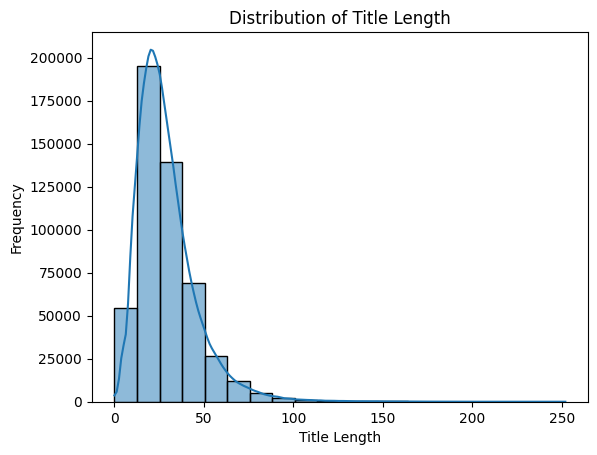

In [ ]:
sns.histplot(data['title_length'], bins=20, kde=True)
plt.title('Distribution of Title Length')
plt.xlabel('Title Length')
plt.ylabel('Frequency')
plt.show()


The histogram illustrates how title lengths are distributed. The peak frequency is approximately 70,000, happening within the 10-40 words range. As title length increases, frequency decreases, spanning from 0 to 200 words.

From this, we can see that a majority of users' titles fall between 10 and 40 words in length.

### 2. Distribution of Selftext Sentiment

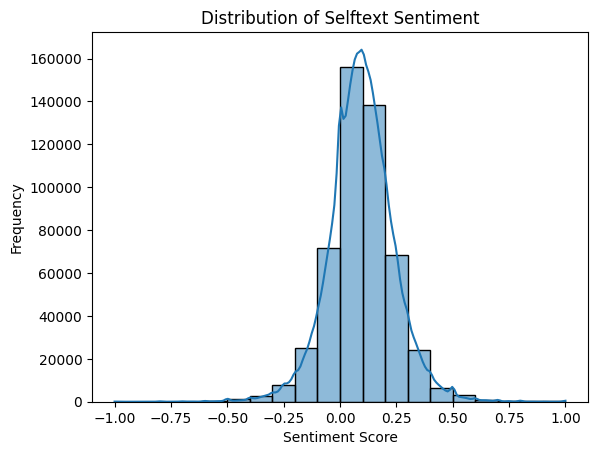

In [ ]:
sns.histplot(data['selftext_sentiment'], bins=20, kde=True)
plt.title('Distribution of Selftext Sentiment')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

The horizontal axis shows the sentiment score, which spans from -1.00 to 1.00, while the vertical axis displays the count of selftexts with that sentiment score, ranging from 0 to 60000. The sentiment score experiences a steep rise from -1.00 to 0.10, with counts increasing to about 61000, and then decreases sharply from 61000 to 0 at a sentiment score of 1.0.

This pattern indicates that a majority of selftexts have a slightly positive sentiment, while a smaller portion exhibit very positive or very negative sentiments.

### 3. Category Distribution

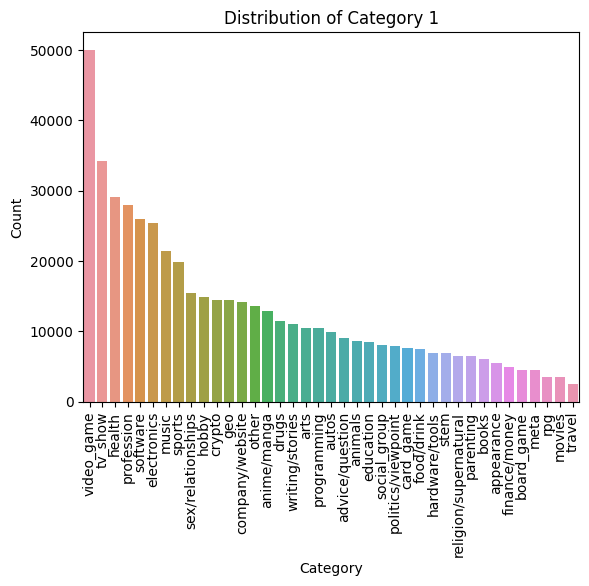

In [ ]:
sns.countplot(data=data, x='category_1', order=data['category_1'].value_counts().index)
plt.title('Distribution of Category 1')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()


It is observed from the chart that the highest bar is around 20,000 and the lowest bar is around 2,500. The number of different categories shows there is a wide range of categories represented in the Category 1 column, with some categories having significantly more posts than others.

### 4. Correlation Heatmap

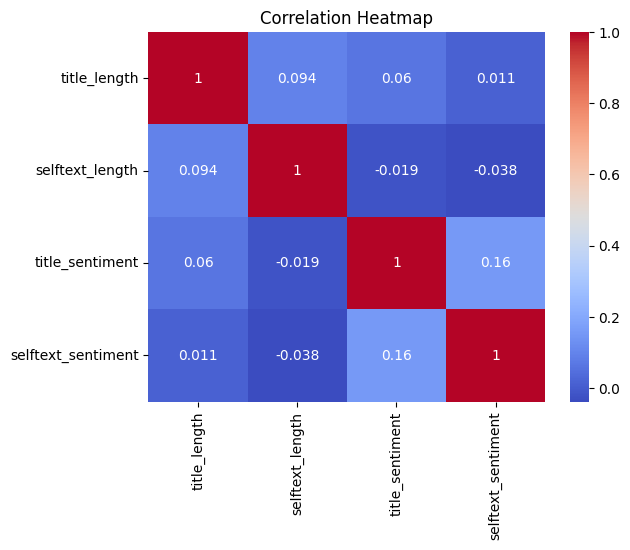

In [ ]:
correlation_matrix = data[['title_length', 'selftext_length', 'title_sentiment', 'selftext_sentiment']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


This image is a correlation heatmap that shows the correlation coefficients between four variables: title_length, selftext_length, title_sentiment, and selftext_sentiment.The cells in the grid are colored according to the correlation coefficient between the two variables, with the colors ranging from dark blue (negative correlation) to dark red (positive correlation). The diagonal cells are colored in dark red, indicating a perfect positive correlation between the variables. This is expected as each variable is perfectly correlated with itself. The cell at the top right corner is colored in light blue, indicating a weak negative correlation between title_length and selftext_sentiment.

### 5. Scatter Plot of Title Length vs. Selftext Length

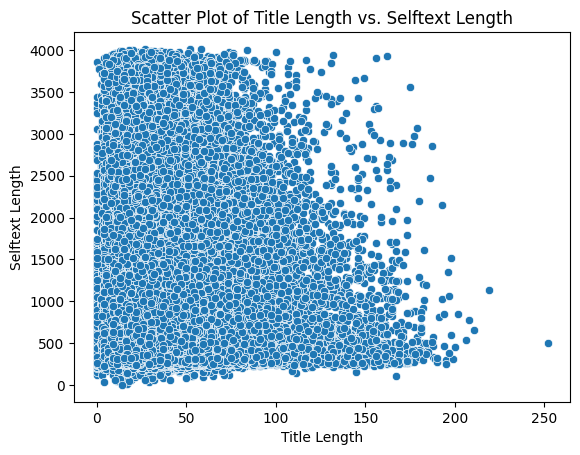

In [ ]:
sns.scatterplot(data=data, x='title_length', y='selftext_length')
plt.title('Scatter Plot of Title Length vs. Selftext Length')
plt.xlabel('Title Length')
plt.ylabel('Selftext Length')
plt.show()

This scatter plot shows the relationship between title length and selftext length. The x-axis represents the title length, while the y-axis represents the selftext length.

The plot shows a positive correlation between title length and selftext length, meaning that as the title length increases, the selftext length also tends to increase.

### 6. Box Plot of Sentiment by Category

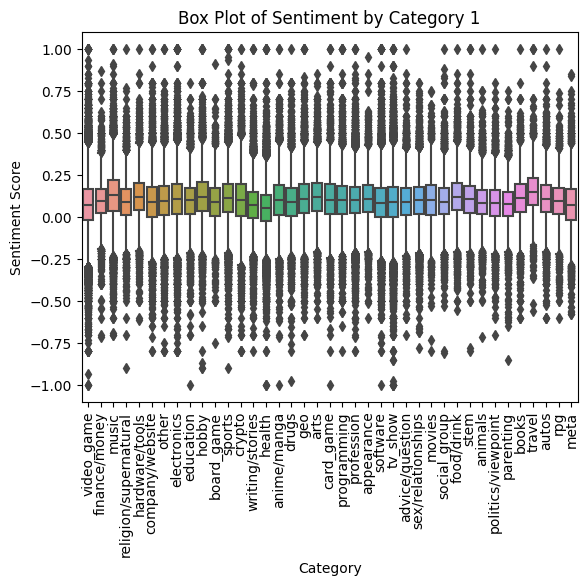

In [ ]:
sns.boxplot(data=data, x='category_1', y='selftext_sentiment')
plt.title('Box Plot of Sentiment by Category 1')
plt.xlabel('Category')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=90)
plt.show()


This box plot shows the distribution of sentiment scores for different categories in category 1. The x-axis represents the category, while the y-axis represents the sentiment score, ranging from -1.00 to 1.00. The categories are represented by different colors: orange, green, blue, purple, and pink. The plot shows that the sentiment scores for the orange and green categories are generally higher than the other categories, meaning that posts in these categories tend to have more positive sentiment. On the other hand, the sentiment scores for the pink category are generally lower than the other categories, meaning that posts in this category tend to have more negative sentiment.

### Category Encoding

In [ ]:
le = LabelEncoder()

data['subreddit'] = le.fit_transform(data['subreddit'])
data['category_1'] = le.fit_transform(data['category_1'])
data['category_2'] = le.fit_transform(data['category_2'])
data['category_3'] = le.fit_transform(data['category_3'])

## User-Item Interaction Matrix

In [ ]:


# Creating a unique user ID for each interaction
data['user_id'] = np.arange(len(data))

# Creating the User-Item Interaction Matrix
interaction_matrix = pd.pivot_table(data, index='user_id', columns='subreddit', values='selftext_length', fill_value=0)

## Model Building

We shall explore collaborative filtering technique: `Single Value Decomposition Model (SVD)` and matrix factorization method: `Alternating Least Squares (ALS)` to build the recommendation model

### Collaborative Filering Using Single Value Decomposition (SVD)

>- SVD is a popular matrix factorization technique that is widely used in recommendation systems. It decomposes the user-item interaction matrix into three matrices, capturing the latent factors that explain the observed interactions.

In [ ]:
# Number of latent factors
n_latent_factors = 10

svd = TruncatedSVD(n_components=n_latent_factors)
user_factors = svd.fit_transform(interaction_matrix)
item_factors = svd.components_.T

# Predicted interactions
predicted_interactions = np.dot(user_factors, item_factors.T)

percent = 1000

Model Evaluation of SVD

In [ ]:
actual_interactions = interaction_matrix.values
rmse = np.sqrt(mean_squared_error(actual_interactions, predicted_interactions))
print(f'RMSE: {rmse}')

RMSE: 28.46144247747306


In [ ]:
def get_top_k(predictions, k):
    # Get the top K indices for each user
    top_k_indices = np.argsort(-predictions, axis=1)[:, :k]

    # Create a binary matrix for top K predictions
    top_k_predictions = np.zeros_like(predictions)
    for i, indices in enumerate(top_k_indices):
        top_k_predictions[i, indices] = 1

    return top_k_predictions

In [ ]:
top_k_predictions = get_top_k(predicted_interactions, k=5)

In [ ]:
print(top_k_predictions)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
def precision_at_k(actual, predicted, k):
    sum_precision = 0
    for a, p in zip(actual, predicted):
        relevant_items = set(np.argsort(a)[-k:])
        recommended_items = set(np.argsort(p)[-k:])
        sum_precision += len(relevant_items & recommended_items) / k
    return sum_precision / len(actual)

def recall_at_k(actual, predicted, k):
    sum_recall = 0
    for a, p in zip(actual, predicted):
        relevant_items = set(np.argsort(a)[-k:])
        recommended_items = set(np.argsort(p)[-k:])
        sum_recall += len(relevant_items & recommended_items) / len(relevant_items)
    return sum_recall / len(actual)

In [ ]:
k = 8
precision_at_k_value = precision_at_k(actual_interactions, top_k_predictions, k)
recall_at_k_value = recall_at_k(actual_interactions, top_k_predictions, k)


print("Precision@k: ", precision_at_k_value * percent)
print("Recall@k: ", recall_at_k_value * percent)

Precision@k:  93.39758144126357
Recall@k:  93.39758144126357


## Using Naive Bayes Algorithm

In [ ]:
RUNNING_KAGGLE_KERNEL = False

In [ ]:
# join the title and selftext
def join_text(row):
    if RUNNING_KAGGLE_KERNEL:
        return row['title'][:100] + " " + row['selftext'][:512]
    else:
        return row['title'] + " " + row['selftext']

data['text'] = data[['title', 'selftext']].apply(join_text, axis=1)

In [ ]:
# take the last 20% as a test set and last 20% is a stratified split (equal proportions of subreddits)

train_split_index = int(len(data) * 0.8)

train_df, test_df = data[:train_split_index], data[train_split_index:]
X_train , X_test  = train_df.text, test_df.text
y_train, y_test   = train_df.subreddit, test_df.subreddit

User-Based Collaborative Filtering

In [ ]:
# take the last 20% as a test set - N.B data is already randomly shuffled,
# and last 20% is a stratified split (equal proportions of subreddits)

train_split_index = int(len(data) * 0.8)

train_df, test_df = data[:train_split_index], data[train_split_index:]
X_train , X_test  = train_df.text, test_df.text
y_train, y_test   = train_df.subreddit, test_df.subreddit

In [ ]:
from sklearn.preprocessing import LabelEncoder

# label encode y

le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test  = le.transform(y_test)

y_train[:5]

array([538,  64, 779, 691, 604], dtype=int64)

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# train a naive bayes model, get predictions

nb_model = MultinomialNB(alpha=0.1)
nb_model.fit(X_train, y_train)

y_pred_proba = nb_model.predict_proba(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

In [ ]:
print('precision@3 =', precision_at_k(y_test, y_pred_proba, 35))

precision@3 = 0.9041707798617966


In [ ]:
print('precision@5 =', precision_at_k(y_test, y_pred_proba, 43))

precision@5 = 0.9159921026653505
